In [ ]:
# 필수 라이브러리
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.metrics import r2_score, mean_squared_error

import os
os.chdir('/content/drive/MyDrive/빅데이터분석연구실/논문작업')

from keras.utils.vis_utils import plot_model
import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model

# CMP 시계열 센서 및 MRR 선정
Sensors=['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_POLISHING_TABLE',  'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET', 
         'MAIN_OUTER_AIR_BAG_PRESSURE', 'PRESSURIZED_CHAMBER_PRESSURE', 'CENTER_AIR_BAG_PRESSURE', 'RIPPLE_AIR_BAG_PRESSURE', 'EDGE_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE',
        'SLURRY_FLOW_LINE_A', 'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C',
        'WAFER_ROTATION', 'STAGE_ROTATION', 'HEAD_ROTATION']

MRR = ['WAFER_ID','AVG_REMOVAL_RATE']

# 그룹별 데이터셋 불러오기
A_low_tr = pd.read_csv('./dataset/A_low_tr.csv')
A_low_te = pd.read_csv('./dataset/A_low_te.csv')

A_high_tr = pd.read_csv('./dataset/A_high_tr.csv')
A_high_te = pd.read_csv('./dataset/A_high_te.csv')

B_tr = pd.read_csv('./dataset/B_tr.csv')
B_te = pd.read_csv('./dataset/B_te.csv')

# 챔버와 시간 순으로 정렬하여 인덱스 설정
B_te.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
B_te.reset_index(inplace=True, drop=False)
B_tr.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
B_tr.reset_index(inplace=True, drop=False)

A_low_te.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_low_te.reset_index(inplace=True, drop=True)
A_low_tr.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_low_tr.reset_index(inplace=True, drop=True)

A_high_te.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_high_te.reset_index(inplace=True, drop=True)
A_high_tr.sort_values(['CHAMBER', 'TIMESTAMP'], inplace=True)
A_high_tr.reset_index(inplace=True, drop=True)

In [ ]:
# 함수1 : 웨이퍼 별 2차원 샘플 데이터를 추출함(웨이퍼, 공정시간, 센서) = (배치, 시간, 변수)
def split_by_wafer(data, Sensors):
  Wafer_IDs = data['WAFER_ID'].unique()
  Wafers = []

  for Wafer_ID in Wafer_IDs:
    Wafers.append(np.array(data[data['WAFER_ID'] == Wafer_ID][Sensors]))
  # print(len(Wafers))

  return Wafers


# 함수2 : 웨이퍼 별로 공정시간이 다르므로 쉐이프를 리사이징함(다운 샘플링, 시간 길이 100으로 고정)
def resize_by_wafer(data_by_wafer, Sensors):
  resized_Wafers = []

  for Wafer_idx in range(len(data_by_wafer)):
    resized_Wafers.append(cv2.resize(data_by_wafer[Wafer_idx], (len(Sensors), 100), interpolation=cv2.INTER_NEAREST))
  print(len(resized_Wafers))

  return np.array(resized_Wafers)


# 함수3 : 단변수로 다운 샘플링
def resize_by_ring(data_by_wafer):
  resized_Wafers = []

  for Wafer_idx in range(len(data_by_wafer)):
    resized_Wafers.append(cv2.resize(data_by_wafer[Wafer_idx], (1, 100), interpolation=cv2.INTER_NEAREST))
  # print(len(resized_Wafers))

  return np.array(resized_Wafers)


# 함수4 : 입력 데이터 최소최대 정규화
def scaling(X_tr, X_te):
  scaled_X_tr = scaler.fit_transform(X_tr.reshape(-1,1))
  scaled_X_tr = scaled_X_tr.reshape(X_tr.shape[0], X_tr.shape[1], X_tr.shape[2], 1)

  scaled_X_te = scaler.fit_transform(X_te.reshape(-1,1))
  scaled_X_te = scaled_X_te.reshape(X_te.shape[0], X_te.shape[1], X_te.shape[2], 1)
  
  scaled_X_tr.shape, scaled_X_te.shape

  return scaled_X_tr, scaled_X_te

In [ ]:
#Sensors = Main_Sensors

# A_low 최종 데이터셋(X_tr_A_low, y_tr_A_low)
A_low_tr_by_wafer = split_by_wafer(A_low_tr, Sensors)
A_low_te_by_wafer = split_by_wafer(A_low_te, Sensors)

A_low_tr_resized = resize_by_wafer(A_low_tr_by_wafer, Sensors)
A_low_te_resized = resize_by_wafer(A_low_te_by_wafer, Sensors)

X_tr_A_low = A_low_tr_resized
X_te_A_low = A_low_te_resized

y_tr_A_low = np.array(A_low_tr[MRR].groupby(by='WAFER_ID', sort=False).mean())
y_te_A_low = np.array(A_low_te[MRR].groupby(by='WAFER_ID', sort=False).mean())

# A_high 최종 데이터셋(X_tr_A_high, y_tr_A_high)
A_high_tr_by_wafer = split_by_wafer(A_high_tr, Sensors)
A_high_te_by_wafer = split_by_wafer(A_high_te, Sensors)

A_high_tr_resized = resize_by_wafer(A_high_tr_by_wafer, Sensors)
A_high_te_resized = resize_by_wafer(A_high_te_by_wafer, Sensors)

X_tr_A_high = A_high_tr_resized
X_te_A_high = A_high_te_resized

y_tr_A_high = np.array(A_high_tr[MRR].groupby(by='WAFER_ID', sort=False).mean())
y_te_A_high = np.array(A_high_te[MRR].groupby(by='WAFER_ID', sort=False).mean())

# B 최종 데이터셋(X_tr_B, y_tr_B)
B_tr_by_wafer = split_by_wafer(B_tr, Sensors)
B_te_by_wafer = split_by_wafer(B_te, Sensors)

B_tr_resized = resize_by_wafer(B_tr_by_wafer, Sensors)
B_te_resized = resize_by_wafer(B_te_by_wafer, Sensors)

X_tr_B=B_tr_resized
X_te_B=B_te_resized

y_tr_B = np.array(B_tr[MRR].groupby(by='WAFER_ID', sort=False).mean())
y_te_B = np.array(B_te[MRR].groupby(by='WAFER_ID', sort=False).mean())

# 딥러닝 모델 인풋에 적합한 스케일링
scaled_X_tr_A_low, scaled_X_te_A_low = scaling(X_tr_A_low, X_te_A_low)
scaled_X_tr_A_high, scaled_X_te_A_high = scaling(X_tr_A_high, X_te_A_high)
scaled_X_tr_B, scaled_X_te_B = scaling(X_tr_B, X_te_B)

798
165
364
73
815
186


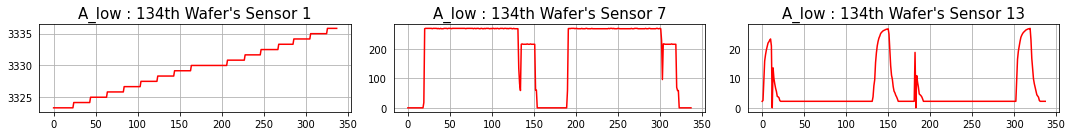

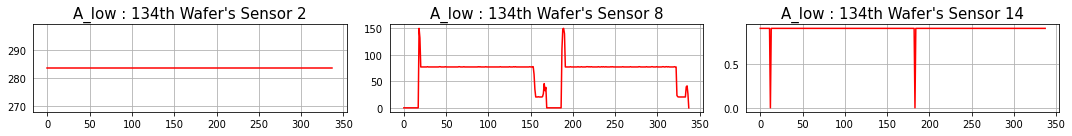

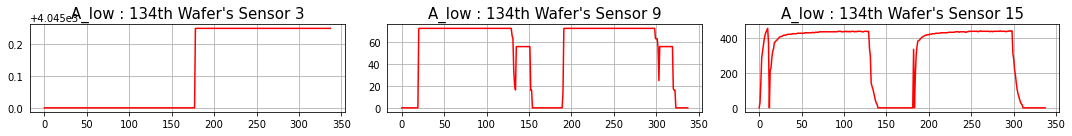

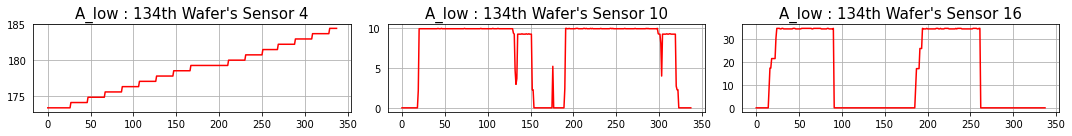

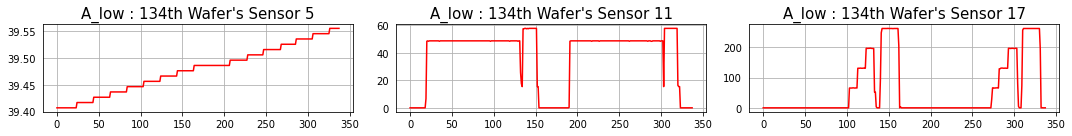

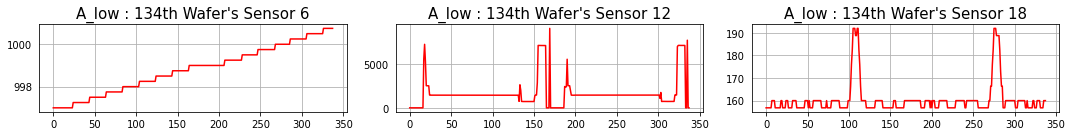

In [ ]:
# A_low_tr resize 전 그래프
idx = 133
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(A_low_te_by_wafer[idx][:,i], color='red')
  axes[0].set_title('A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(A_low_te_by_wafer[idx][:,i+6], color='red')
  axes[1].set_title('A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(A_low_te_by_wafer[idx][:,i+12], color='red')
  axes[2].set_title('A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

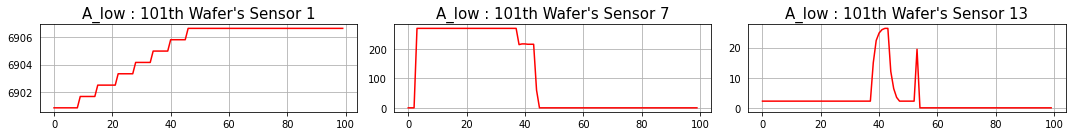

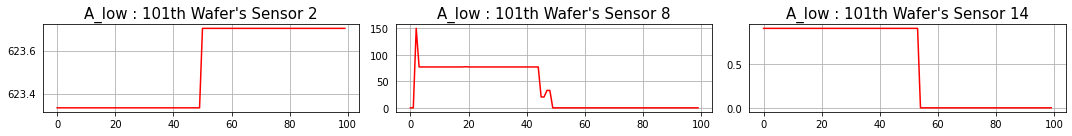

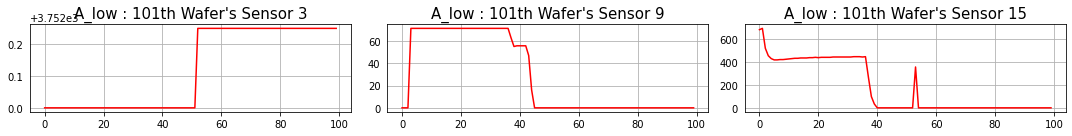

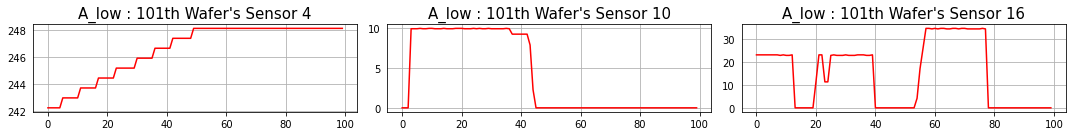

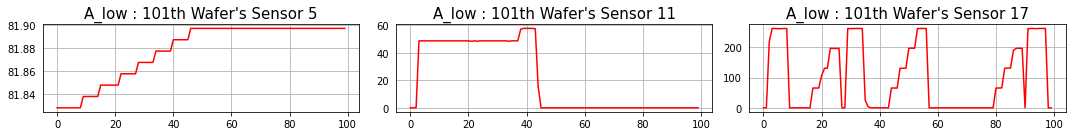

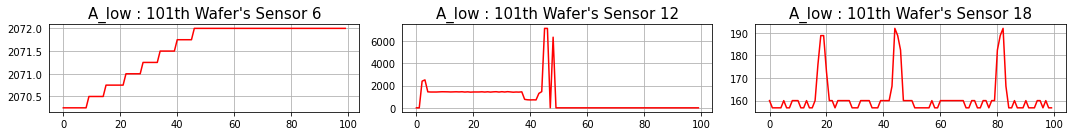

In [ ]:
# A_low_tr resize 후 그래프
idx = 100
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(X_te_A_low[idx][:,i], color='red')
  axes[0].set_title('A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(X_te_A_low[idx][:,i+6], color='red')
  axes[1].set_title('A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(X_te_A_low[idx][:,i+12], color='red')
  axes[2].set_title('A_low : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

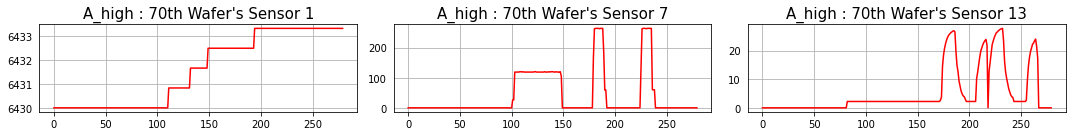

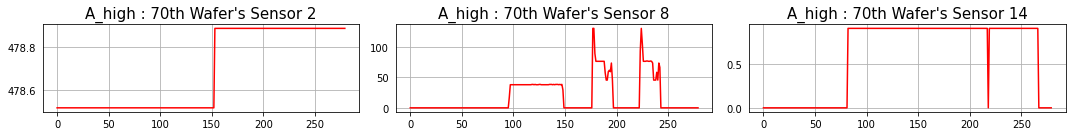

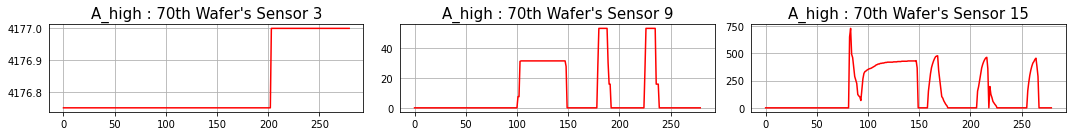

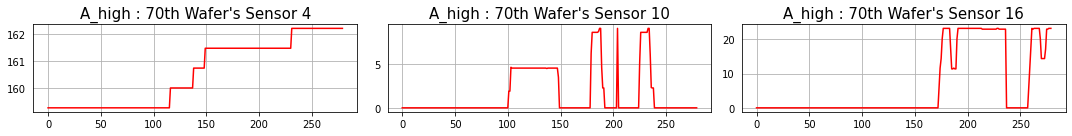

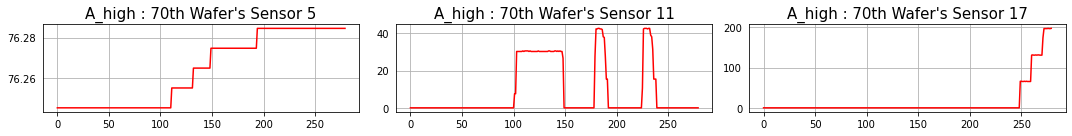

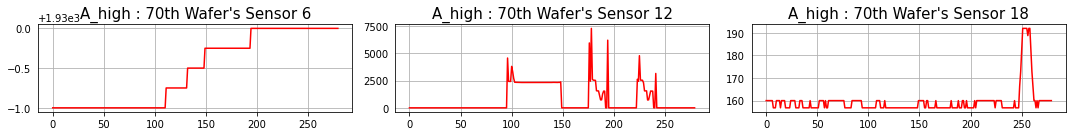

In [ ]:
# A_high_tr resize 전 그래프
idx = 69
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(A_high_te_by_wafer[idx][:,i], color='red')
  axes[0].set_title('A_high : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(A_high_te_by_wafer[idx][:,i+6], color='red')
  axes[1].set_title('A_high : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(A_high_te_by_wafer[idx][:,i+12], color='red')
  axes[2].set_title('A_high : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

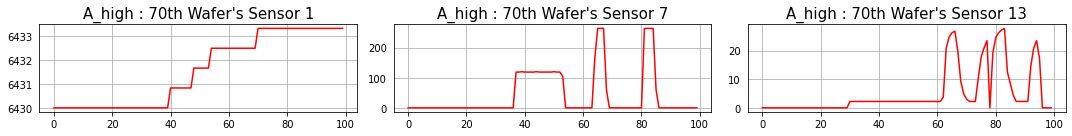

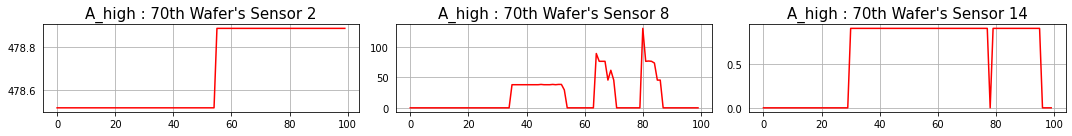

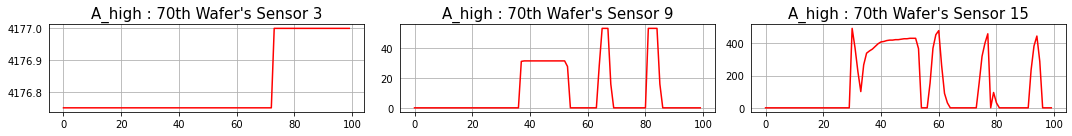

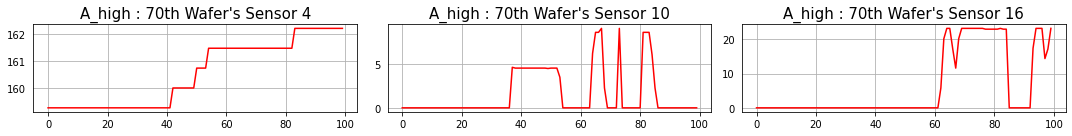

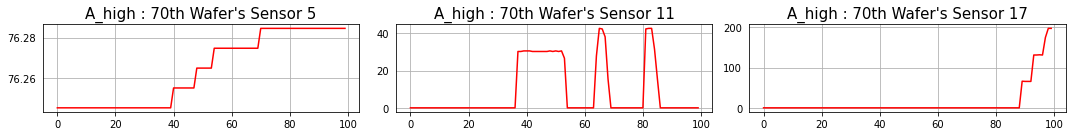

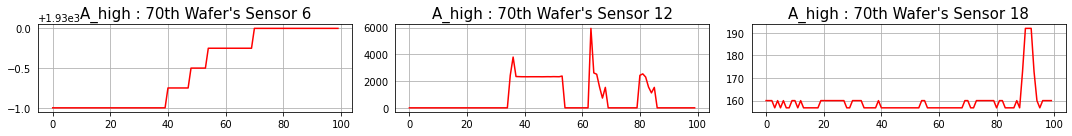

In [ ]:
# A_high_tr resize 후 그래프
idx = 69
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(X_te_A_high[idx][:,i], color='red')
  axes[0].set_title('A_high : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(X_te_A_high[idx][:,i+6], color='red')
  axes[1].set_title('A_high : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(X_te_A_high[idx][:,i+12], color='red')
  axes[2].set_title('A_high : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

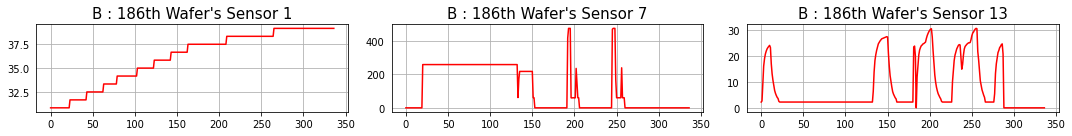

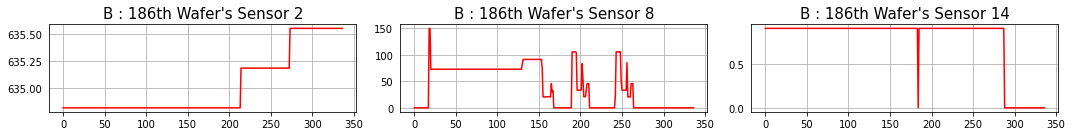

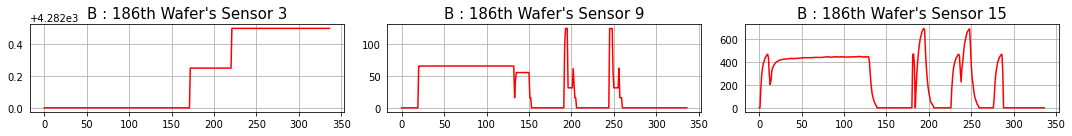

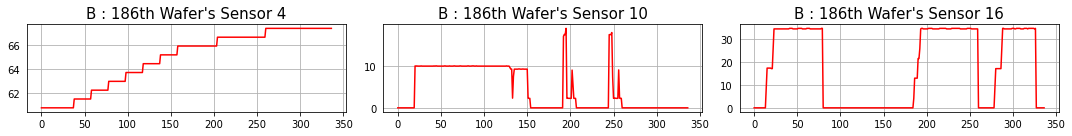

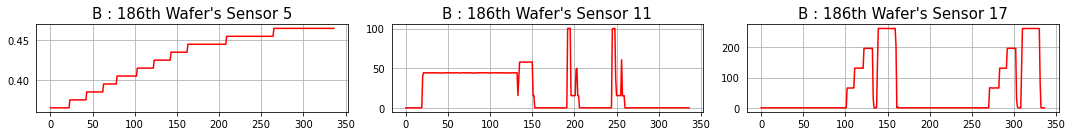

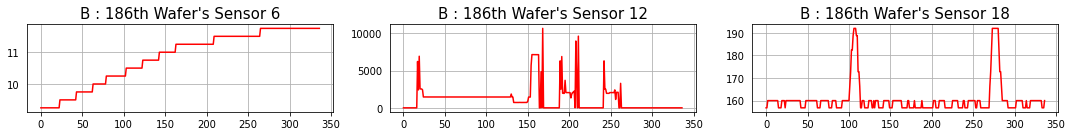

In [ ]:
# B resize 전 그래프
idx = 185
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(B_te_by_wafer[idx][:,i], color='red')
  axes[0].set_title('B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(B_te_by_wafer[idx][:,i+6], color='red')
  axes[1].set_title('B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(B_te_by_wafer[idx][:,i+12], color='red')
  axes[2].set_title('B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

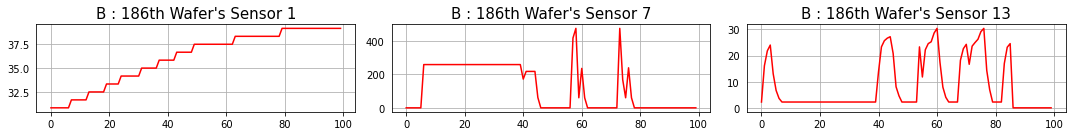

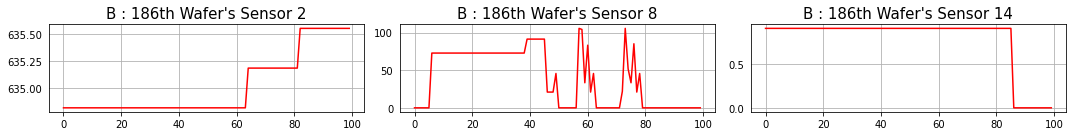

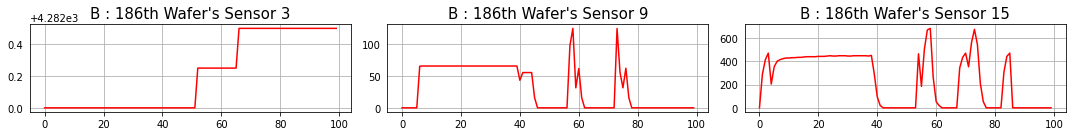

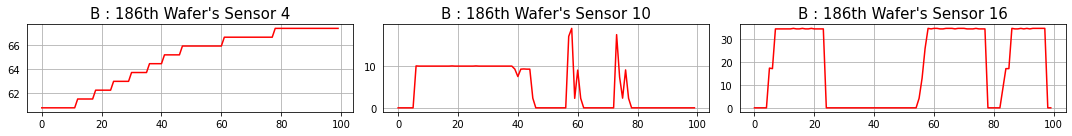

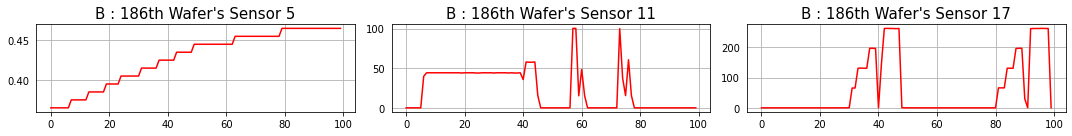

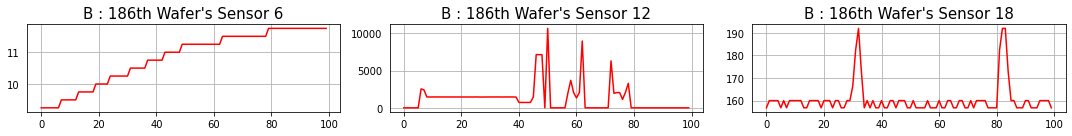

In [ ]:
# B resize 후 그래프
idx = 185
size_graph = 6

for i in range(size_graph):
  fig, axes = plt.subplots(1, 3, figsize=(15,2))
  axes[0].plot(X_te_B[idx][:,i], color='red')
  axes[0].set_title('B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+1), fontdict={'fontsize':15})
  axes[0].grid()

  axes[1].plot(X_te_B[idx][:,i+6], color='red')
  axes[1].set_title('B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+7), fontdict={'fontsize':15})
  axes[1].grid()

  axes[2].plot(X_te_B[idx][:,i+12], color='red')
  axes[2].set_title('B : '+str(idx+1)+'th Wafer\'s Sensor '+str(i+13), fontdict={'fontsize':15})
  axes[2].grid()

  for ax in fig.axes:
    plt.sca(ax)
    plt.tick_params(axis='y', which='major', labelsize=10, left=False, labelleft=True)
    plt.tight_layout()

In [ ]:
# 필수 라이브러리
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import os
os.chdir('/content/drive/MyDrive/빅데이터분석연구실/논문작업')
import data_utils as utils

from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [ ]:
# 데이터셋 불러오기
X_train_path = './dataset/X_train_merged.csv'
y_train_path = './dataset/CMP-training-removalrate.csv'
X_valid_path = './dataset/X_valid_merged.csv'
y_valid_path = './dataset/CMP-validation-removalrate.csv'
X_test_path = './dataset/X_test_merged.csv'
y_test_path = './dataset/CMP-test-removalrate.csv'

X_train, y_train = utils.load_dataset(X_train_path, y_train_path)
X_valid, y_valid = utils.load_dataset(X_valid_path, y_valid_path)
X_test, y_test = utils.load_dataset(X_test_path, y_test_path)

X_A_tr, X_B_tr, y_A_tr, y_B_tr = utils.split_stage(X_train, y_train)
X_A_va, X_B_va, y_A_va, y_B_va = utils.split_stage(X_valid, y_valid)
X_A_te, X_B_te, y_A_te, y_B_te = utils.split_stage(X_test, y_test)

A_tr = utils.merge_xy(X_A_tr, y_A_tr)
B_tr = utils.merge_xy(X_B_tr, y_B_tr)
A_va = utils.merge_xy(X_A_va, y_A_va)
B_va = utils.merge_xy(X_B_va, y_B_va)
A_te = utils.merge_xy(X_A_te, y_A_te)
B_te = utils.merge_xy(X_B_te, y_B_te)

A_tr = utils.outlier(A_tr.iloc[:, 3:])
B_tr = utils.outlier(B_tr.iloc[:, 3:])

A_va = A_va.iloc[:,1:]
B_va = B_va.iloc[:,1:]

A_low_tr, A_high_tr = utils.split_MRR(A_tr)
A_low_va, A_high_va = utils.split_MRR(A_va)
A_low_te, A_high_te = utils.split_MRR(A_te)

In [ ]:
A_low_va.sort_values('TIMESTAMP', inplace=True)
A_low_va.reset_index(drop=True, inplace=True)

A_high_va.sort_values('TIMESTAMP', inplace=True)
A_high_va.reset_index(drop=True, inplace=True)

B_va.sort_values('TIMESTAMP', inplace=True)
B_va.reset_index(drop=True, inplace=True)

In [ ]:
A_low_tr.sort_values('TIMESTAMP', inplace=True)
A_low_tr.reset_index(drop=True, inplace=True)

A_low_te.sort_values('TIMESTAMP', inplace=True)
A_low_te.reset_index(drop=True, inplace=True)

In [ ]:
A_high_tr.sort_values('TIMESTAMP', inplace=True)
A_high_tr.reset_index(drop=True, inplace=True)

A_high_te.sort_values('TIMESTAMP', inplace=True)
A_high_te.reset_index(drop=True, inplace=True)

In [ ]:
B_tr.sort_values('TIMESTAMP', inplace=True)
B_tr.reset_index(drop=True, inplace=True)

B_te.sort_values('TIMESTAMP', inplace=True)
B_te.reset_index(drop=True, inplace=True)

In [ ]:
A_low_tr = pd.read_csv('./dataset/A_low_tr.csv')
A_low_te = pd.read_csv('./dataset/A_low_te.csv')
A_high_tr = pd.read_csv('./dataset/A_high_tr.csv')
A_high_te = pd.read_csv('./dataset/A_high_te.csv')
B_tr = pd.read_csv('./dataset/B_tr.csv')
B_te = pd.read_csv('./dataset/B_te.csv')

In [ ]:
process_params = ['USAGE_OF_BACKING_FILM', 'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET', 'USAGE_OF_DRESSER', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_POLISHING_TABLE',
        'MAIN_OUTER_AIR_BAG_PRESSURE', 'PRESSURIZED_CHAMBER_PRESSURE', 'CENTER_AIR_BAG_PRESSURE', 'RIPPLE_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE', 'EDGE_AIR_BAG_PRESSURE',
        'SLURRY_FLOW_LINE_A', 'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C',
        'WAFER_ROTATION', 'STAGE_ROTATION', 'HEAD_ROTATION',
        'AVG_REMOVAL_RATE']

In [ ]:
usage_params = ['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER','USAGE_OF_POLISHING_TABLE', 'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET']
pressure_params = ['MAIN_OUTER_AIR_BAG_PRESSURE', 'PRESSURIZED_CHAMBER_PRESSURE', 'CENTER_AIR_BAG_PRESSURE', 'RIPPLE_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE', 'EDGE_AIR_BAG_PRESSURE']
flow_params = ['SLURRY_FLOW_LINE_A', 'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C']
rotation_params = ['WAFER_ROTATION', 'STAGE_ROTATION', 'HEAD_ROTATION']

In [ ]:
A_low_ID = A_low_te['WAFER_ID']

In [ ]:
A_low_true = pd.DataFrame(y_test_A_low)

In [ ]:
A_low_pred = pd.DataFrame(A_low.predict(X_test_A_low))

In [ ]:
A_low_result =pd.concat([A_low_ID,A_low_true, A_low_pred], axis=1)
A_low_result

,WAFER_ID,AVG_REMOVAL_RATE,0
0,-4224160592,56.1786,58.922195
1,-4224160592,56.1786,58.922195
2,-4224160592,56.1786,58.922195
3,-4224160592,56.1786,58.922195
4,-4224160592,56.1786,58.922195
...,...,...,...
71796,33494174,70.7889,72.058914
71797,33494174,70.7889,72.059471
71798,33494174,70.7889,72.058914
71799,33494174,70.7889,72.047714


In [ ]:
mean_squared_error(A_low_true, A_low_pred)

4.798389514169119

In [ ]:
A_low_result_by_wafer =A_low_result.groupby('WAFER_ID').mean()

In [ ]:
A_low_result_by_wafer

,AVG_REMOVAL_RATE,0
WAFER_ID,,
-4226160404,60.44715,61.394997
-4224160686,57.25230,56.358524
-4224160592,56.17860,59.672760
-4220160654,69.84885,73.284302
-4141512092,70.56045,72.768730
...,...,...
4217773710,56.61465,55.554626
4221773698,70.59630,70.828224
4223773496,60.99510,61.573032


In [ ]:
A_low_true_by_wafer =A_low_result_by_wafer.iloc[:,0]
A_low_pred_by_wafer =A_low_result_by_wafer.iloc[:,1]
#mean_squared_error(A_low_true_by_wafer, A_low_pred_by_wafer)

In [ ]:
A_high_ID = A_high_te['WAFER_ID']

In [ ]:
A_high_true = pd.DataFrame(y_test_A_high)
A_high_pred = pd.DataFrame(A_high.predict(X_test_A_high))

In [ ]:
A_high_result =pd.concat([A_high_ID, A_high_true, A_high_pred], axis=1)
A_high_result

,WAFER_ID,AVG_REMOVAL_RATE,0
0,373446766,153.26100,151.950470
1,373446766,153.26100,151.950470
2,373446766,153.26100,151.950470
3,373446766,153.26100,151.950470
4,373446766,153.26100,151.995880
...,...,...,...
19992,2076207432,155.61465,155.312347
19993,2076207432,155.61465,155.312347
19994,2076207432,155.61465,155.256058
19995,2076207432,155.61465,155.256058


In [ ]:
A_high_result_by_wafer = A_high_result.groupby('WAFER_ID').mean()

In [ ]:
A_high_true_by_wafer =A_high_result_by_wafer.iloc[:,0]
A_high_pred_by_wafer =A_high_result_by_wafer.iloc[:,1]
#mean_squared_error(A_high_true_by_wafer, A_high_pred_by_wafer)

In [ ]:
B_ID = B_te['WAFER_ID']
B_true = pd.DataFrame(y_test_B)
B_pred = pd.DataFrame(B.predict(X_test_B))

In [ ]:
B_result =pd.concat([B_ID,B_true,B_pred], axis=1)
B_result

,WAFER_ID,AVG_REMOVAL_RATE,0
0,-887170152,64.3881,65.544724
1,-887170152,64.3881,65.552742
2,-887170152,64.3881,65.553398
3,-887170152,64.3881,65.553398
4,-887170152,64.3881,65.553398
...,...,...,...
64459,29494100,86.4969,90.885117
64460,29494100,86.4969,90.884682
64461,29494100,86.4969,90.884682
64462,29494100,86.4969,90.884682


In [ ]:
B_result_by_wafer = B_result.groupby('WAFER_ID').mean()

In [ ]:
B_true_by_wafer =B_result_by_wafer.iloc[:,0]
B_pred_by_wafer =B_result_by_wafer.iloc[:,1]


In [ ]:
mean_squared_error(B_true_by_wafer, B_pred_by_wafer)

9.928968635662297

In [ ]:
A_low_B_result=A_low_result.append(B_result, ignore_index=True)
total_result=A_low_B_result.append(A_high_result,ignore_index=True)

In [ ]:
total_result_by_wafer = total_result.groupby('WAFER_ID').mean()

In [ ]:
total_true_by_wafer=total_result_by_wafer.iloc[:,0]
total_pred_by_wafer=total_result_by_wafer.iloc[:,1]
mean_squared_error(total_true_by_wafer, total_pred_by_wafer)

8.076341580592686

In [ ]:
A_low_true_by_wafer.to_csv('A_low_true_by_wafer.csv')
A_low_pred_by_wafer.to_csv('A_low_pred_by_wafer.csv')
A_high_true_by_wafer.to_csv('A_high_true_by_wafer.csv')
A_high_pred_by_wafer.to_csv('A_high_pred_by_wafer.csv')
B_true_by_wafer.to_csv('B_true_by_wafer.csv')
B_pred_by_wafer.to_csv('B_pred_by_wafer.csv')
total_true_by_wafer.to_csv('total_true_by_wafer.csv')
total_pred_by_wafer.to_csv('total_pred_by_wafer.csv')

In [ ]:
X_train = A_low_tr[process_params].iloc[:,:-1]
y_train_A_low = A_low_tr[process_params].iloc[:,-1]

X_test = A_low_te[process_params].iloc[:,:-1]
y_test_A_low = A_low_te[process_params].iloc[:,-1]

X_train_A_low = np.array(X_train).reshape((X_train.shape[0],18,1))
X_test_A_low = np.array(X_test).reshape((X_test.shape[0],18,1))

In [ ]:
X_train = A_low_tr[usage_params].iloc[:,:-1]
y_train_A_low = A_low_tr[usage_params].iloc[:,-1]

X_test = A_low_te[usage_params].iloc[:,:-1]
y_test_A_low = A_low_te[usage_params].iloc[:,-1]

X_train_A_low = np.array(X_train).reshape((X_train.shape[0],6,1))
X_test_A_low = np.array(X_test).reshape((X_test.shape[0],6,1))

In [ ]:
X_train = A_high_tr[process_params].iloc[:,:-1]
y_train_A_high = A_high_tr[process_params].iloc[:,-1]

X_test = A_high_te[process_params].iloc[:,:-1]
y_test_A_high = A_high_te[process_params].iloc[:,-1]

X_train_A_high = np.array(X_train).reshape((X_train.shape[0],6,3,1))
X_test_A_high = np.array(X_test).reshape((X_test.shape[0],6,3,1))

In [ ]:
X_train_usage = A_high_tr[usage_params]
X_train_pressure = A_high_tr[pressure_params]
X_train_flow = A_high_tr[flow_params]
X_train_rotation = A_high_tr[rotation_params]
y_train_A_high = A_high_tr[process_params].iloc[:,-1]

X_test_usage = A_high_te[usage_params]
X_test_pressure = A_high_te[pressure_params]
X_test_flow = A_high_te[flow_params]
X_test_rotation = A_high_te[rotation_params]
y_test_A_high = A_high_te[process_params].iloc[:,-1]

In [ ]:
X_train_A_high_u = np.array(X_train_usage).reshape((X_train_usage.shape[0],6,1))
X_train_A_high_p = np.array(X_train_pressure).reshape((X_train_pressure.shape[0],6,1))
X_train_A_high_f = np.array(X_train_flow).reshape((X_train_flow.shape[0],3,1))
X_train_A_high_r = np.array(X_train_rotation).reshape((X_train_rotation.shape[0],3,1))

X_test_A_high_u = np.array(X_test_usage).reshape((X_test_usage.shape[0],6,1))
X_test_A_high_p = np.array(X_test_pressure).reshape((X_test_pressure.shape[0],6,1))
X_test_A_high_f = np.array(X_test_flow).reshape((X_test_flow.shape[0],3,1))
X_test_A_high_r = np.array(X_test_rotation).reshape((X_test_rotation.shape[0],3,1))

In [ ]:
X_train = B_tr[process_params].iloc[:,:-1]
y_train_B = B_tr[process_params].iloc[:,-1]

X_test = B_te[process_params].iloc[:,:-1]
y_test_B = B_te[process_params].iloc[:,-1]

X_train_B = np.array(X_train).reshape((X_train.shape[0],18,1))
X_test_B = np.array(X_test).reshape((X_test.shape[0],18,1))

In [ ]:
X_train = B_tr[main_process_params].iloc[:,:-1]
y_train_B = B_tr[main_process_params].iloc[:,-1]

X_test = B_te[main_process_params].iloc[:,:-1]
y_test_B = B_te[main_process_params].iloc[:,-1]

X_train_B = np.array(X_train).reshape((X_train.shape[0],8,1))
X_test_B = np.array(X_test).reshape((X_test.shape[0],8,1))

In [ ]:
X_train_A_high_u.shape, X_train_A_high_p.shape, X_train_A_high_f.shape, X_train_A_high_r.shape

((101399, 6, 1), (101399, 6, 1), (101399, 3, 1), (101399, 3, 1))

In [ ]:
# main sensor8, A low 4.79
Input = keras.layers.Input(shape=(18, 1))

x = keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, activation='relu')(Input)
x = keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, activation='relu')(x)
x = keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu')(x)
x = keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation='relu')(x)

x = keras.layers.AveragePooling1D(pool_size=2, strides=1)(x)
x = keras.layers.LSTM(128, return_sequences=True, input_shape=(18,128))(x)
x = keras.layers.LSTM(64, activation='relu')(x)
                  
Output1 = keras.layers.Dense(1)(x)

model1 = keras.models.Model(inputs=Input, outputs=Output1)

optimizer= keras.optimizers.Adam(0.001)
model1.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 16, 16)            64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 32)            1568      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 128)           24704     
_________________________________________________________________
average_pooling1d (AveragePo (None, 9, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 9, 128)            131584

In [ ]:
# main sensor8, A low 4.79
Input = keras.layers.Input(shape=(18, 1))
#x = tf.keras.layers.BatchNormalization()(Input)
x = keras.layers.Conv1D(filters=16, kernel_size=2, strides=1, activation='relu')(Input)
#x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.Conv1D(filters=512, kernel_size=2, strides=1, activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = keras.layers.AveragePooling1D(pool_size=2, strides=1)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
                  
Output1 = keras.layers.Dense(1)(x)

model1 = keras.models.Model(inputs=Input, outputs=Output1)

optimizer= keras.optimizers.Adam(0.001)
model1.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

In [ ]:
epochs = 10
batch_size = 50

file_name='test_conv2d_epoch_{}_batch_{}.h5'.format(epochs, batch_size)

In [ ]:
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('LR:{}'.format(model.optimizer.lr.numpy()))

cp = ModelCheckpoint(file_name,
                     monitor='val_loss',
                     save_best_only=True)

ReduceLR = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.9)

In [ ]:
model1.fit(X_train_A_low, y_train_A_low, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test_A_low, y_test_A_low), validation_batch_size=10, verbose=1, callbacks=[cp, ReduceLR])

In [ ]:
model1.fit(X_train_A_high, y_train_A_high, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test_A_high, y_test_A_high), validation_batch_size=10, verbose=1, callbacks=[cp, ReduceLR])

In [ ]:
file_name='type_epoch_{}_batch_{}_var_18.h5'.format(epochs, batch_size)

cp = ModelCheckpoint(file_name,
                     monitor='val_loss',
                     save_best_only=True)
ReduceLR = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.9)

model.fit(X_train_A_low, y_train_A_low, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test_A_low, y_test_A_low), validation_batch_size=20, verbose=1, callbacks=[cp, ReduceLR, PrintLR()])

In [ ]:
file_name='A_high_test3_epoch_{}_batch_{}_var_18.h5'.format(epochs, batch_size)

cp = ModelCheckpoint(file_name,
                     monitor='val_loss',
                     save_best_only=True)
ReduceLR = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.9)

model1.fit(X_train_A_high, y_train_A_high, batch_size=batch_size, epochs=epochs,
          validation_data=(X_test_A_high, y_test_A_high), validation_batch_size=10, verbose=1, callbacks=[cp, ReduceLR, PrintLR()])

In [ ]:
A_high = load_model('./conv2d_epoch_10_batch_50.h5')
#A_high = load_model('./연구산출물/모델/A_high_mse_849.h5')
#B = load_model('B_mse975_epoch_50_batch_50_var_8.h5')

#A_low.evaluate(X_test_A_low, y_test_A_low), A_high.evaluate(X_test_A_high, y_test_A_high), B.evaluate(X_test_B, y_test_B)

In [ ]:
A_low_pred= A_low.predict(X_test_A_low)

In [ ]:
A_high_pred=A_high.predict(X_test_A_high)

In [ ]:
B_pred=B.predict(X_test_B)

In [ ]:
test=np.append(A_low_pred, A_high_pred)
tot_pred = np.append(test,B_pred)

In [ ]:
test1=np.append(np.array(y_test_A_low), np.array(y_test_A_high))
tot_true = np.append(test1, np.array(y_test_B))
tot_true

array([56.1786, 56.1786, 56.1786, ..., 86.4969, 86.4969, 86.4969])

In [ ]:
cam_model_A_low = keras.Model(A_low.input, outputs=(A_low.layers[-3].output, A_low.layers[-1].output))

features_A_low, results_A_low = cam_model_A_low.predict(X_test_A_low)

In [ ]:
cam_model_A_high = keras.Model(A_high.input, outputs=(A_high.layers[-3].output, A_high.layers[-1].output))

features_A_high, results_A_high = cam_model_A_high.predict(X_test_A_high)

In [ ]:
cam_model_B = keras.Model(B.input, outputs=(B.layers[-3].output, B.layers[-1].output))

features_B, results_B = cam_model_B.predict(X_test_B)

In [ ]:
gap_weights = cam_model_A_low.layers[-1].get_weights()[0]
gap_weights

In [ ]:
np.dot(features_A_low[2], gap_weights).mean()

60.21316

In [ ]:
results_A_low[2]

array([60.677258], dtype=float32)

In [ ]:
#pred = CAM의 평균(가중치*피쳐맵의 평균) + bias

In [ ]:
def avg_cam(model, features):
  sum_cam_output = np.zeros((8, 1))
  gap_weights = model.layers[-1].get_weights()[0] # 512 X 1

  for idx in range(features.shape[0]):
    sum_cam_output += np.dot(features[idx], gap_weights)
  print(sum_cam_output)
  return sum_cam_output/features.shape[0]

In [ ]:
avg_cam_A_low = scaler.fit_transform(avg_cam_A_low)

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(avg_cam_A_low, (1,8)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Process Parameters',fontsize=15)
plt.xticks(np.arange(0,8), labels=np.arange(1,9))
plt.title('A low CAM', fontsize=25, pad=20)
for i in range(avg_cam_A_low.shape[0]):
  plt.text(i, 0, np.round(avg_cam_A_low[i][0],2), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

In [ ]:
avg_cam_A_high=avg_cam(cam_model_A_high, features_A_high)

avg_cam_A_high = scaler.fit_transform(avg_cam_A_high)

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(avg_cam_A_high, (1,8)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Process Parameters',fontsize=15)
plt.xticks(np.arange(0,8), labels=np.arange(1,9))
plt.title('A high CAM', fontsize=25, pad=20)
for i in range(avg_cam_A_high.shape[0]):
  plt.text(i, 0, np.round(avg_cam_A_high[i][0],2), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

In [ ]:
avg_cam_B = avg_cam(cam_model_B, features_B)

avg_cam_B = scaler.fit_transform(avg_cam_B)

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(avg_cam_B, (1,8)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Process Parameters',fontsize=15)
plt.xticks(np.arange(0,8), labels=np.arange(1,9))
plt.title('B CAM', fontsize=25, pad=20)
for i in range(avg_cam_B.shape[0]):
  plt.text(i, 0, np.round(avg_cam_B[i][0],2), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

In [ ]:
tot_avg_cam =(avg_cam_A_low+avg_cam_A_high+avg_cam_B)/3
tot_avg_cam = scaler.fit_transform(tot_avg_cam)
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(tot_avg_cam, (1,8)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Process Parameters',fontsize=15)
plt.xticks(np.arange(0,8), labels=np.arange(1,9))
plt.title('Total CMP Dataset CAM', fontsize=25, pad=20)
for i in range(tot_avg_cam.shape[0]):
  plt.text(i, 0, np.round(tot_avg_cam[i][0],2), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

In [ ]:
def avg_cam(model, features):
  sum_cam_output = np.zeros((18, 1))
  gap_weights = model.layers[-1].get_weights()[0] # 512 X 1

  for idx in range(features.shape[0]):
    sum_cam_output += np.dot(features[idx], gap_weights)
  print(sum_cam_output)
  return sum_cam_output/features.shape[0]

In [ ]:
avg_cam_A_low = avg_cam(cam_model_A_low, features_A_low)

avg_cam_A_low = scaler.fit_transform(avg_cam_A_low)

[[18998324.94898987]
 [15300780.49237061]
 [10121284.71356201]
 [ 4939542.78682518]
 [ 3876931.06680918]
 [ 4291053.9521023 ]
 [ 4024853.27365503]
 [ 2989672.04913464]
 [ 2164844.80671549]
 [ 1466420.59971666]
 [ 1484021.58805609]
 [ 1480826.18189859]
 [ 1413244.18489301]
 [ 1189794.71349978]
 [ 2055061.70925713]
 [ 4192343.46490097]
 [ 5507306.76800728]
 [ 6230938.21057129]]


In [ ]:
avg_cam_A_high=avg_cam(cam_model_A_high, features_A_high)

avg_cam_A_high = scaler.fit_transform(avg_cam_A_high)

In [ ]:
avg_cam_A_high

array([[653.15413441],
       [118.45067621],
       [119.58412968],
       [119.34018106],
       [118.13055245],
       [118.46692524],
       [119.53966011],
       [128.66154677],
       [118.35715162],
       [119.96714612],
       [131.62920259],
       [133.79531923],
       [125.97901758],
       [125.54834291],
       [120.75786711],
       [120.70212926],
       [121.31374353],
       [116.2526049 ]])

In [ ]:
avg_cam_B = avg_cam(cam_model_B, features_B)

avg_cam_B = scaler.fit_transform(avg_cam_B)

In [ ]:
np.save('avg_cam_A_low', avg_cam_A_low)

In [ ]:
np.save('avg_cam_A_high_final', avg_cam_A_high)

In [ ]:
np.save('avg_cam_B_final', avg_cam_B)

In [ ]:
np.save('avg_cam_tot_final', tot_avg_cam)

In [ ]:
avg_cam_A_low=np.load('./연구산출물/해석/avg_cam_A_low_final.npy')
avg_cam_A_high=np.load('./연구산출물/해석/avg_cam_A_high_final.npy')
avg_cam_B=np.load('./연구산출물/해석/avg_cam_B_final.npy')

In [ ]:
avg_cam_tot=np.load('./연구산출물/해석/avg_cam_tot_final.npy')

In [ ]:
cam_A_low_usage = avg_cam_A_low[0:6]
cam_A_low_pressure = avg_cam_A_low[6:12]
cam_A_low_slurry = avg_cam_A_low[12:15]
cam_A_low_rotation = avg_cam_A_low[15:18]

In [ ]:
sensor_type_cam_A_low=[cam_A_low_usage.mean(), cam_A_low_pressure.mean(), cam_A_low_slurry.mean(), cam_A_low_rotation.mean()]

In [ ]:
sensor_type_cam_A_high=[avg_cam_A_high[0:6].mean(),
avg_cam_A_high[6:12].mean(),
avg_cam_A_high[12:15].mean(),
avg_cam_A_high[15:18].mean()]
sensor_type_cam_A_high

[0.5731466851039623,
 0.11149159266165316,
 0.022108713944042888,
 0.04591493532293874]

In [ ]:
sensor_type_cam_B=[avg_cam_B[0:6].mean(),
avg_cam_B[6:12].mean(),
avg_cam_B[12:15].mean(),
avg_cam_B[15:18].mean()]
sensor_type_cam_B

[0.332566730622888,
 0.1114580724899366,
 0.04154644788551035,
 0.3493785920621241]

In [ ]:
sensor_type_cam_A_low=np.array(sensor_type_cam_A_low)
sensor_type_cam_A_high = np.array(sensor_type_cam_A_high)
sensor_type_cam_B = np.array(sensor_type_cam_B)

In [ ]:
sensor_type_cam_total=(np.array(sensor_type_cam_A_low)+np.array(sensor_type_cam_A_high)+np.array(sensor_type_cam_B))/3

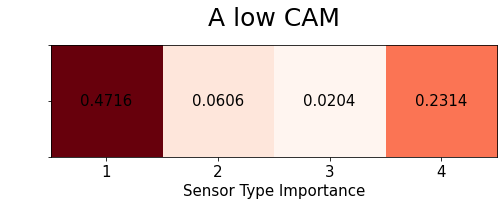

In [ ]:
plt.figure(figsize=(8,5))
plt.imshow(tf.reshape(sensor_type_cam_A_low, (1,4)), cmap=plt.cm.Reds)
plt.rc('font', size=15)
plt.xlabel('Sensor Type Importance',fontsize=15)
plt.xticks(np.arange(0,4), labels=np.arange(1,5))
plt.title('A low CAM', fontsize=25, pad=20)
for i in range(sensor_type_cam_A_low.shape[0]):
  plt.text(i, 0, np.round(sensor_type_cam_A_low[i],4), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

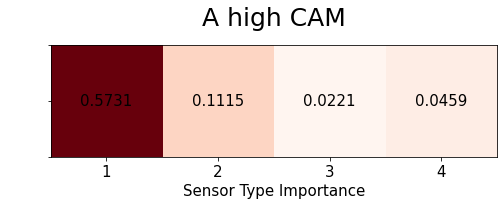

In [ ]:
plt.figure(figsize=(8,5))
plt.imshow(tf.reshape(sensor_type_cam_A_high, (1,4)), cmap=plt.cm.Reds)
plt.rc('font', size=15)
plt.xlabel('Sensor Type Importance',fontsize=15)
plt.xticks(np.arange(0,4), labels=np.arange(1,5))
plt.title('A high CAM', fontsize=25, pad=20)
for i in range(sensor_type_cam_A_high.shape[0]):
  plt.text(i, 0, np.round(sensor_type_cam_A_high[i],4), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

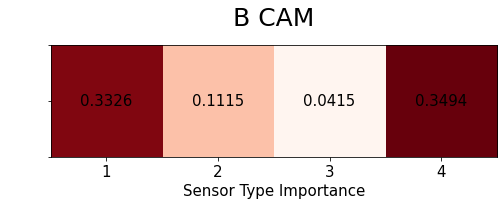

In [ ]:
plt.figure(figsize=(8,5))
plt.imshow(tf.reshape(sensor_type_cam_B, (1,4)), cmap=plt.cm.Reds)
plt.rc('font', size=15)
plt.xlabel('Sensor Type Importance',fontsize=15)
plt.xticks(np.arange(0,4), labels=np.arange(1,5))
plt.title('B CAM', fontsize=25, pad=20)
for i in range(sensor_type_cam_B.shape[0]):
  plt.text(i, 0, np.round(sensor_type_cam_B[i],4), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

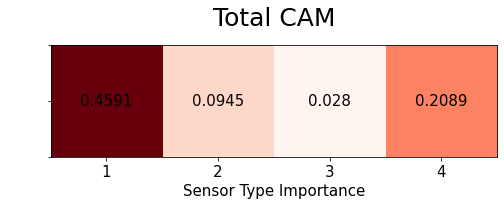

In [ ]:
plt.figure(figsize=(8,5))
plt.imshow(tf.reshape(sensor_type_cam_total, (1,4)), cmap=plt.cm.Reds)
plt.rc('font', size=15)
plt.xlabel('Sensor Type Importance',fontsize=15)
plt.xticks(np.arange(0,4), labels=np.arange(1,5))
plt.title('Total CAM', fontsize=25, pad=20)
for i in range(sensor_type_cam_total.shape[0]):
  plt.text(i, 0, np.round(sensor_type_cam_total[i],4), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

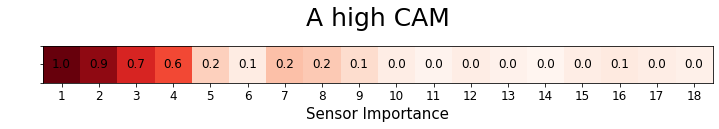

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(avg_cam_A_high, (1,18)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Sensor Importance',fontsize=15)
plt.xticks(np.arange(0,18), labels=np.arange(1,19))
plt.title('A high CAM', fontsize=25, pad=20)
for i in range(avg_cam_A_high.shape[0]):
  plt.text(i, 0, np.round(avg_cam_A_high[i][0],1), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

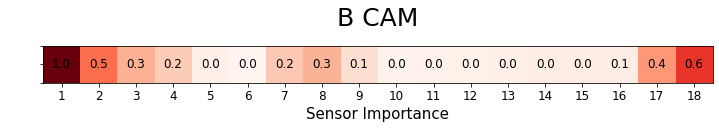

In [ ]:
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(avg_cam_B, (1,18)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Sensor Importance',fontsize=15)
plt.xticks(np.arange(0,18), labels=np.arange(1,19))
plt.title('B CAM', fontsize=25, pad=20)
for i in range(avg_cam_B.shape[0]):
  plt.text(i, 0, np.round(avg_cam_B[i][0],1), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

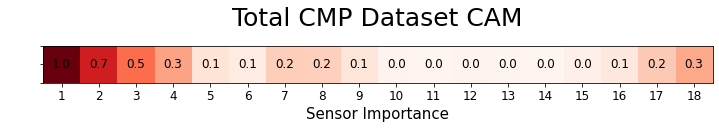

In [ ]:
#avg_cam_tot =(avg_cam_A_low+avg_cam_A_high+avg_cam_B)/3
#avg_cam_tot = scaler.fit_transform(avg_cam_tot)
plt.figure(figsize=(12,5))
plt.imshow(tf.reshape(avg_cam_tot, (1,18)), cmap=plt.cm.Reds)
plt.rc('font', size=12)
plt.xlabel('Sensor Importance',fontsize=15)
plt.xticks(np.arange(0,18), labels=np.arange(1,19))
plt.title('Total CMP Dataset CAM', fontsize=25, pad=20)
for i in range(avg_cam_tot.shape[0]):
  plt.text(i, 0, np.round(avg_cam_tot[i][0],1), horizontalalignment='center', verticalalignment='center')
plt.yticks(color='W')
plt.show()

In [ ]:
avg_cam_B=np.load('avg_cam_B_final.npy')

In [ ]:
avg_cam_B

array([[0.53929725],
       [0.46275977],
       [0.93044034],
       [0.40627618],
       [0.45670074],
       [0.48468902],
       [0.39978804],
       [0.36808085],
       [0.3884191 ],
       [0.38613436],
       [0.39408983],
       [0.38097131],
       [0.38047314],
       [0.37363082],
       [0.36810854],
       [1.        ],
       [0.1181227 ],
       [0.        ]])

In [ ]:
r2_score(A_low_true, A_low_pred)

0.8461051615710684

In [ ]:
A_low_true.to_csv('A_low_true.csv')
A_low_pred.to_csv('A_low_pred.csv')
A_high_true.to_csv('A_high_true.csv')
A_high_pred.to_csv('A_high_pred.csv')
B_true.to_csv('B_true.csv')
B_pred.to_csv('B_pred.csv')

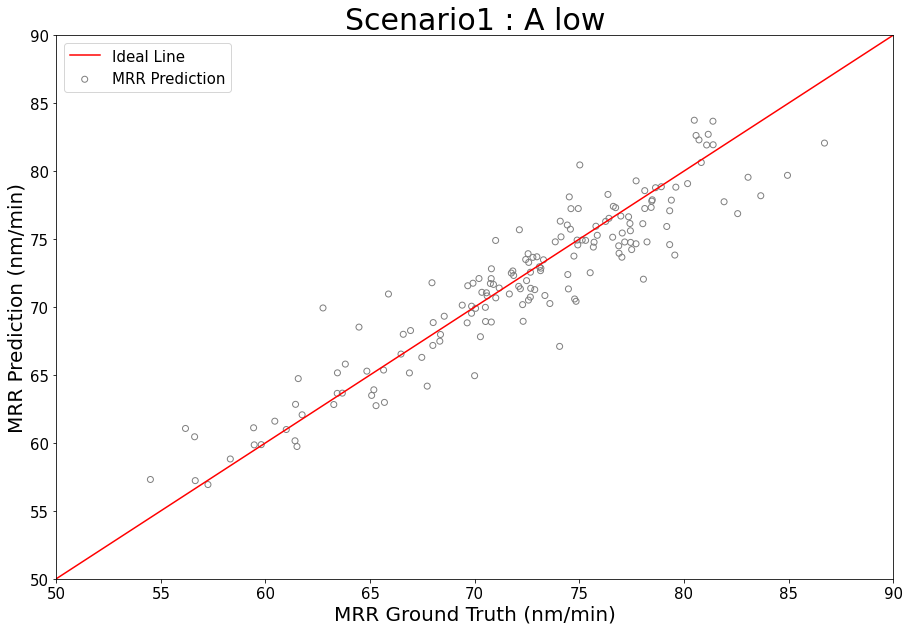

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Scenario1 : A low', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(A_low_true_by_wafer, A_low_pred_by_wafer, marker='o', edgecolors='grey', facecolors='none', label='MRR Prediction')
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)
x = [a for a in range(50,95)]

plt.xlim((50,90))
plt.ylim((50,90))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

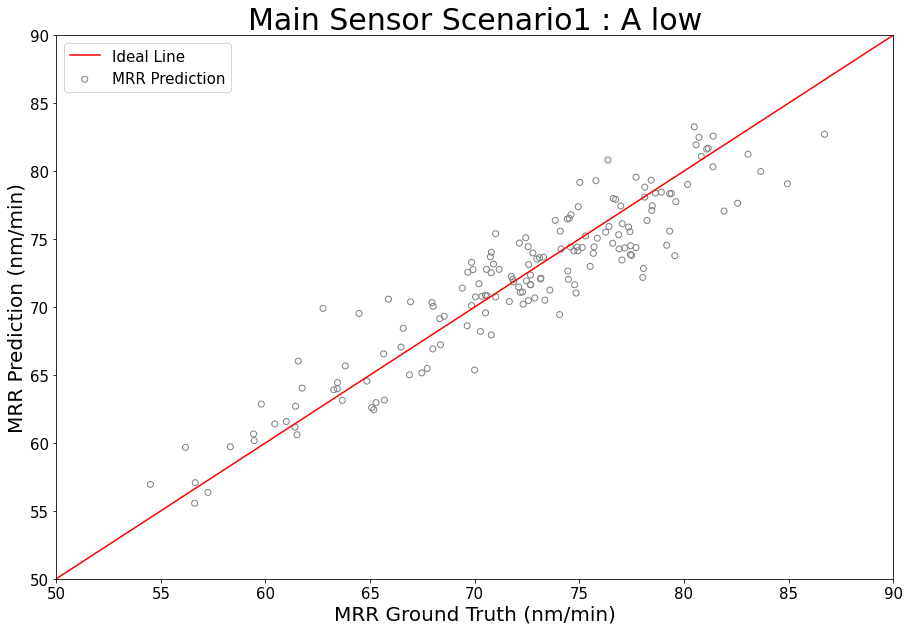

In [ ]:
#main sensor
plt.figure(figsize=(15,10))
plt.title('Main Sensor Scenario1 : A low', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(A_low_true_by_wafer, A_low_pred_by_wafer, marker='o', edgecolors='grey', facecolors='none', label='MRR Prediction')
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)
x = [a for a in range(50,95)]

plt.xlim((50,90))
plt.ylim((50,90))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

In [ ]:
r2_score(A_low_true_by_wafer, A_low_pred_by_wafer)

0.8627337336409855

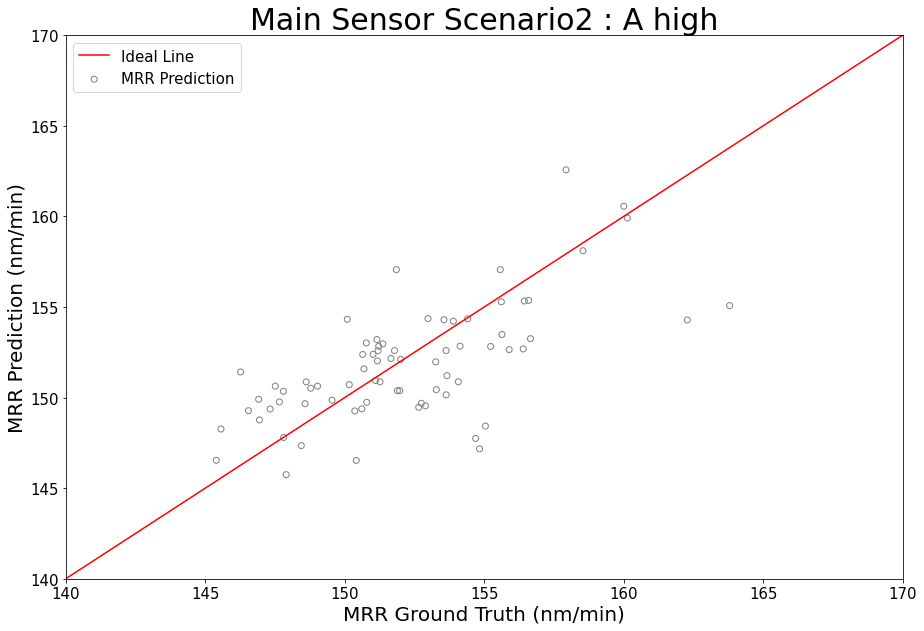

In [ ]:
# main sensor
plt.figure(figsize=(15,10))
plt.title('Main Sensor Scenario2 : A high', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(A_high_true_by_wafer, A_high_pred_by_wafer, marker='o', edgecolors='grey', facecolors='none', label='MRR Prediction')
plt.xlabel('MRR Ground Truth (nm/min)',fontsize=20)
plt.ylabel('MRR Prediction (nm/min)',fontsize=20)
x = [a for a in range(140,175)]
plt.xlim((140,170))
plt.ylim((140,170))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

In [ ]:
r2_score(A_high_true_by_wafer, A_high_pred_by_wafer)

0.4037373288235113

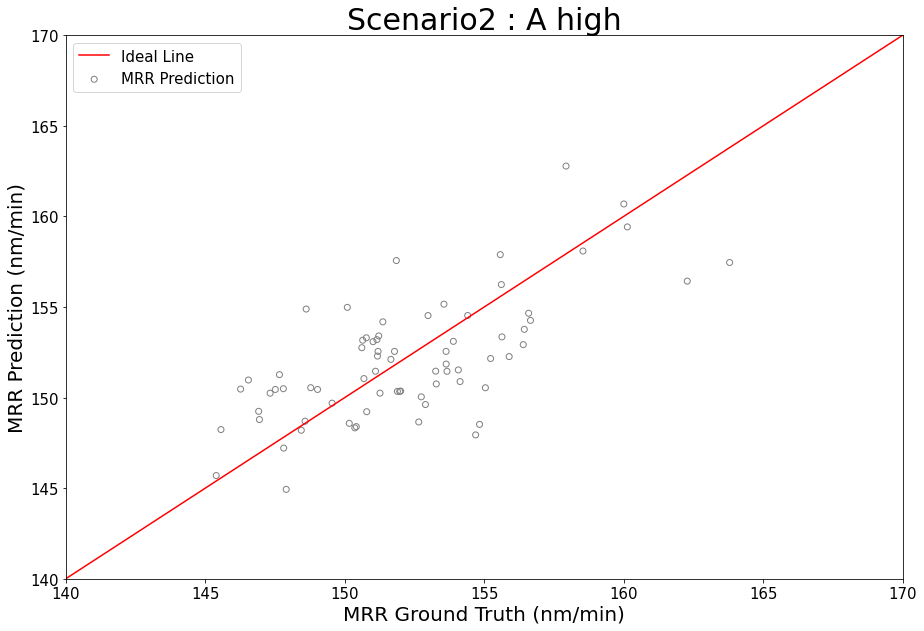

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Scenario2 : A high', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(A_high_true_by_wafer, A_high_pred_by_wafer, marker='o', edgecolors='grey', facecolors='none', label='MRR Prediction')
plt.xlabel('MRR Ground Truth (nm/min)',fontsize=20)
plt.ylabel('MRR Prediction (nm/min)',fontsize=20)
x = [a for a in range(140,175)]
plt.xlim((140,170))
plt.ylim((140,170))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

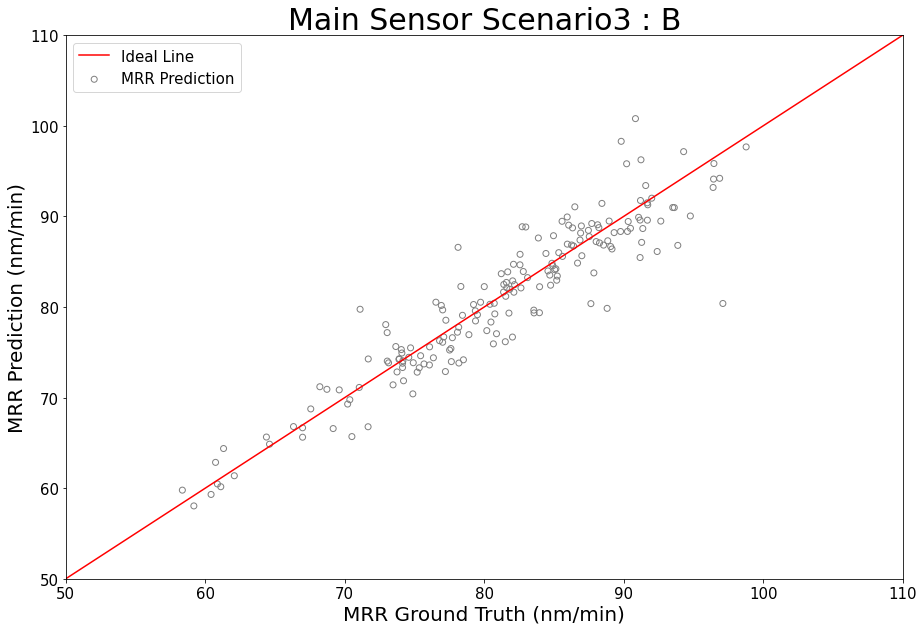

In [ ]:
# main sensor
plt.figure(figsize=(15,10))
plt.title('Main Sensor Scenario3 : B', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(B_true_by_wafer, B_pred_by_wafer, marker='o', edgecolors='grey', facecolors='none', label='MRR Prediction')
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)
x = [a for a in range(50,115)]

plt.xlim((50,110))
plt.ylim((50,110))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

In [ ]:
r2_score(B_true_by_wafer, B_pred_by_wafer)

0.863554846954743

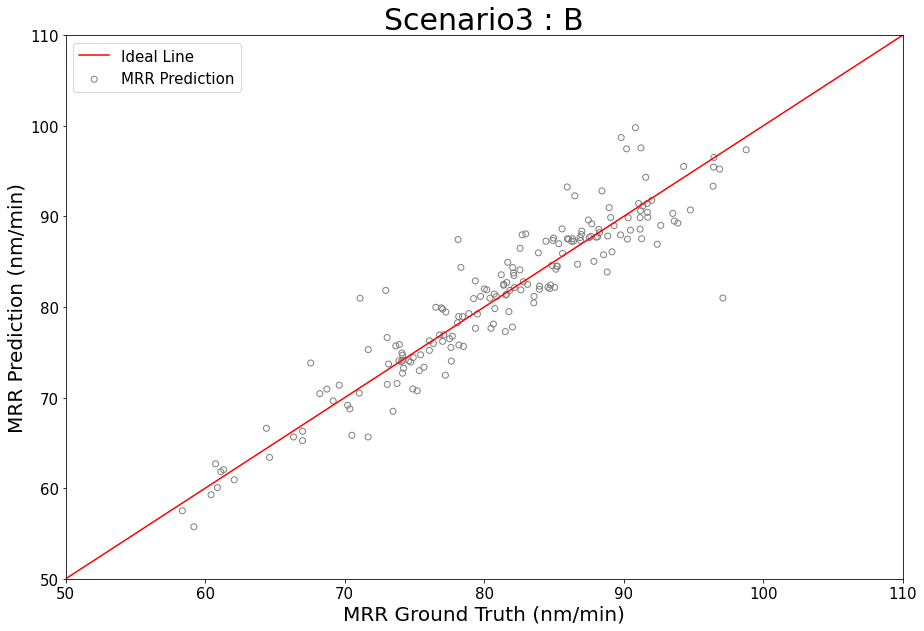

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Scenario3 : B', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(B_true_by_wafer, B_pred_by_wafer, marker='o', edgecolors='grey', facecolors='none', label='MRR Prediction')
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)
x = [a for a in range(50,115)]

plt.xlim((50,110))
plt.ylim((50,110))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

In [ ]:
r2_score(total_true_by_wafer, total_pred_by_wafer)

0.9909067553129766

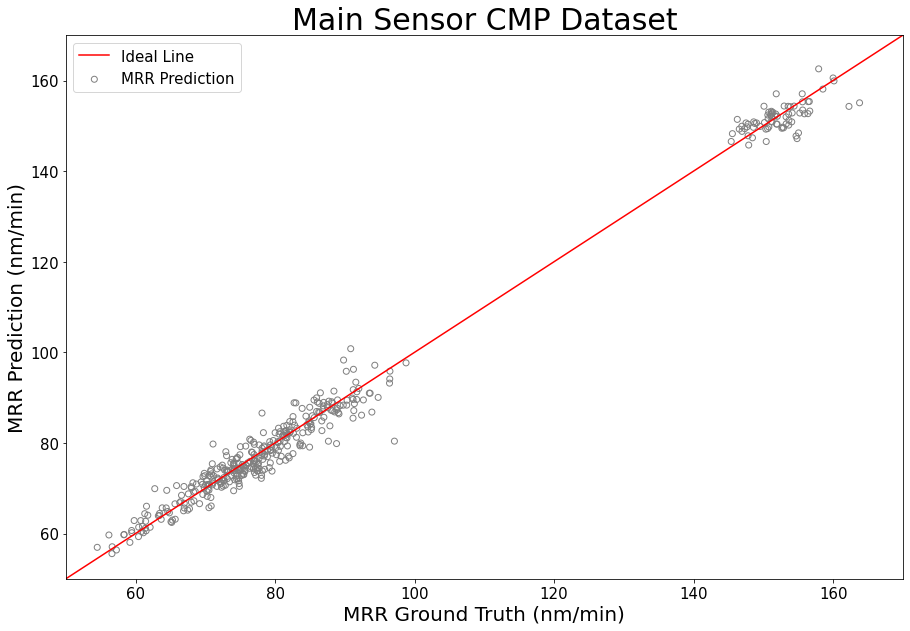

In [ ]:
# main sensor
plt.figure(figsize=(15,10))
plt.title('Main Sensor CMP Dataset', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(total_true_by_wafer, total_pred_by_wafer, marker='o', facecolors='none', edgecolors='grey', label='MRR Prediction')
x = [a for a in range(50,175)]
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)

plt.xlim((50,170))
plt.ylim((50,170))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

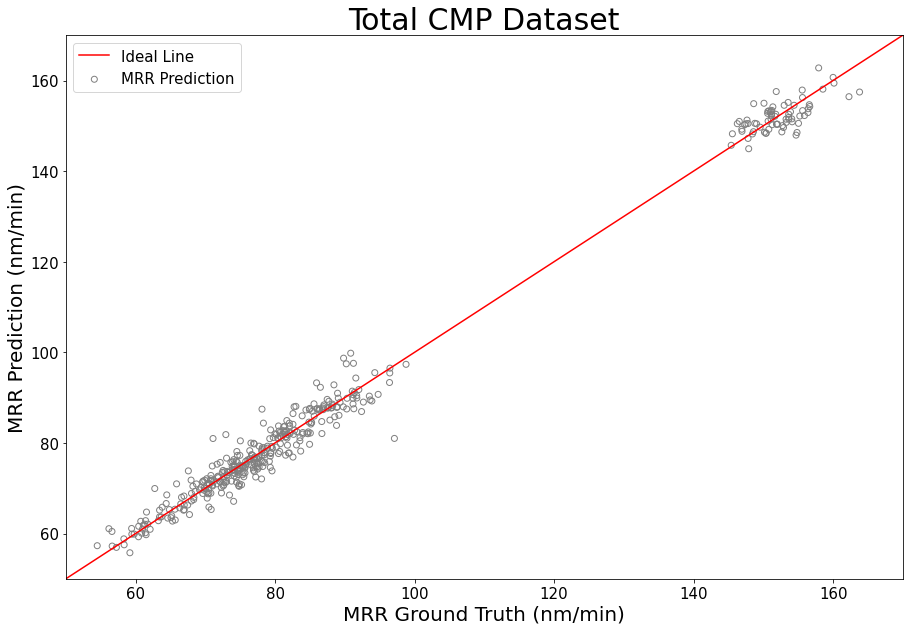

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Total CMP Dataset', fontsize=30)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)

plt.scatter(total_true_by_wafer, total_pred_by_wafer, marker='o', facecolors='none', edgecolors='grey', label='MRR Prediction')
x = [a for a in range(50,175)]
plt.xlabel('MRR Ground Truth (nm/min)', fontsize=20)
plt.ylabel('MRR Prediction (nm/min)', fontsize=20)

plt.xlim((50,170))
plt.ylim((50,170))
plt.plot(x,x,'r',label='Ideal Line')

plt.legend()

In [ ]:
A_low_B_true=A_low_true.append(B_true,ignore_index=True)

In [ ]:
total_true=A_low_B_true.append(A_high_true, ignore_index=True)

In [ ]:
A_low_pred=pd.Series(A_low_pred.reshape((A_low_pred.shape[0],)))
A_high_pred=pd.Series(A_high_pred.reshape((A_high_pred.shape[0],)))
B_pred = pd.Series(B_pred.reshape((B_pred.shape[0],)))

In [ ]:
A_low_B_pred= A_low_pred.append(B_pred,ignore_index=True)

In [ ]:
total_pred = A_low_B_pred.append(A_high_pred, ignore_index=True)

In [ ]:
total_pred.to_csv('total_pred_#156262.csv')

In [ ]:
total_true.to_csv('total_true_#156262.csv')

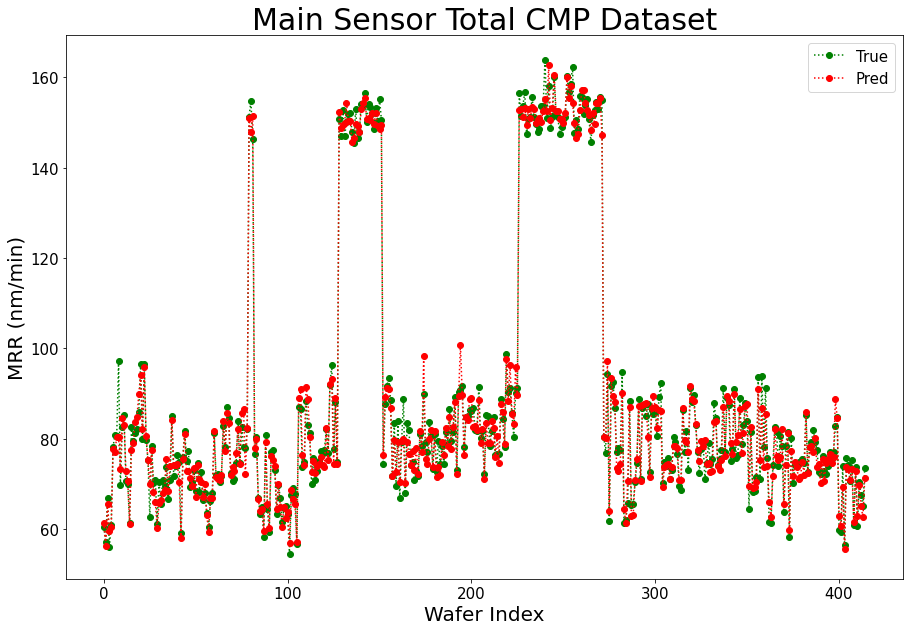

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Main Sensor Total CMP Dataset', fontsize=30)
plt.plot(np.array(total_true_by_wafer),'g', label='True', marker='o', linestyle=':')
plt.plot(np.array(total_pred_by_wafer),'r', label='Pred', marker='o', linestyle=':')

plt.xlabel('Wafer Index', fontsize=20)
plt.ylabel('MRR (nm/min)', fontsize=20)
plt.legend()
plt.rc('legend', fontsize=15)

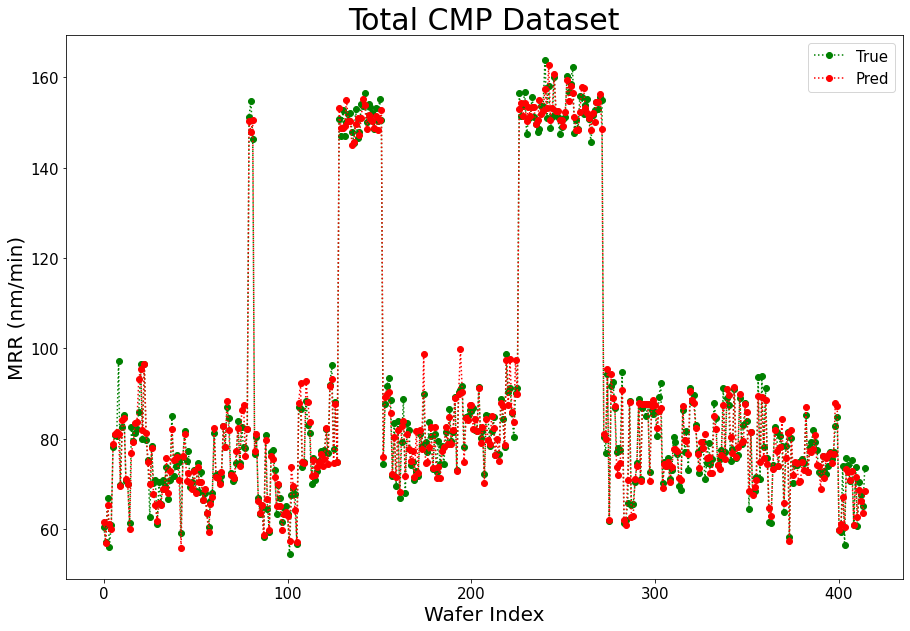

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Total CMP Dataset', fontsize=30)
plt.plot(np.array(total_true_by_wafer),'g', label='True', marker='o', linestyle=':')
plt.plot(np.array(total_pred_by_wafer),'r', label='Pred', marker='o', linestyle=':')

plt.xlabel('Wafer Index', fontsize=20)
plt.ylabel('MRR (nm/min)', fontsize=20)
plt.legend()
plt.rc('legend', fontsize=15)

In [ ]:
np.sqrt(7.22)

2.6870057685088806

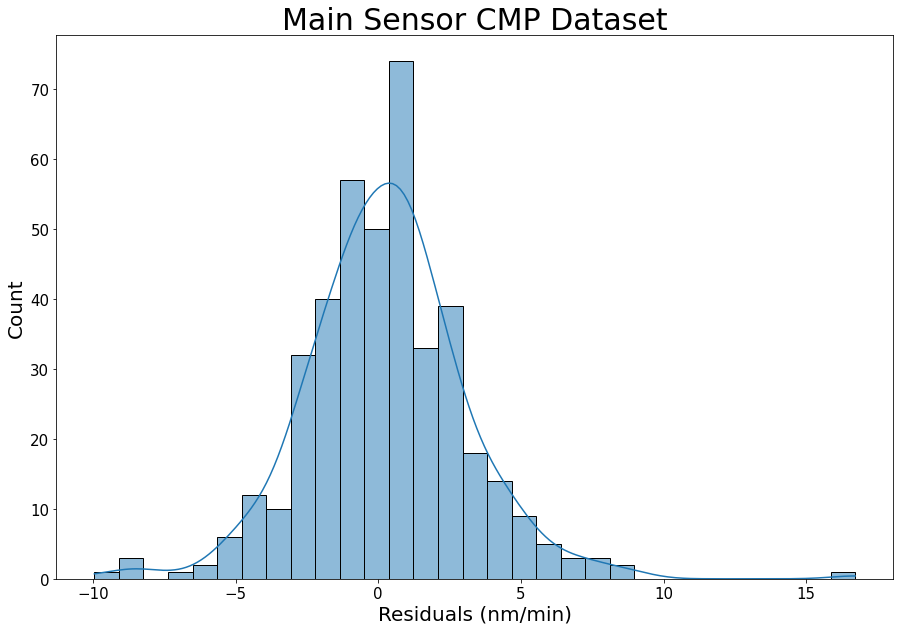

In [ ]:
plt.figure(figsize=(15,10))
residuals = total_true_by_wafer - total_pred_by_wafer
plt.title('Main Sensor CMP Dataset', fontsize=30)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (nm/min)', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.show()

In [ ]:
np.std(residuals)

2.82914470312962